# Chapter 7 - Moving Beyond Linearity

[7.1 Polynomial Regression](#7.1-Polynomial-Regression)

[7.2 Step Functions](#7.2-Step-Functions)

[7.3 Basis Functions](#7.3-Basis-Functions)

[7.4 Regression Splines](#7.4-Regression-Splines)

[7.5 Smoothing Splines](#7.5-Smoothing-Splines)

[7.6 Local Regression](#7.6-Local-Regression)

[7.7 Generalized Additive Models](#7.7-Generalized-Additive-Models)
> [7.7.1 GAMs for Regression Problems](#7.7.1-GAMs-for-Regression-Problems)</br>
> [7.7.2 GAMs for Classification-Problems](#7.7.2-GAMs-for-Classification-Problems)

[7.8 Lab: Non linear Modeling](#7.8-Lab:-Non-linear-Modeling)

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn import neighbors
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix

from plot_lm import plot_lm

import re

%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
df_wage = pd.read_csv('Data/Wage.csv')
df_wage.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
for col_name in df_wage.columns:
    if df_wage[col_name].dtype == 'object':
        # get list of categories
        cat_list = np.sort(df_wage[col_name].unique())
        # create a categorical dtype that is ordered for the columns that makes sense
        cat_dtype = CategoricalDtype(cat_list, ordered=True if col_name in ['education', 'health'] else False)        
        df_wage[col_name] = df_wage[col_name].astype(cat_dtype)
        # strip '#. ' from the categories names
        df_wage[col_name].cat.categories  = [re.sub(r"\d+.\s+", "", cat) for cat in cat_list]
        print(f'{col_name}: {df_wage[col_name].cat.categories.values}')
df_wage.head(3)

sex: ['Male']
maritl: ['Never Married' 'Married' 'Widowed' 'Divorced' 'Separated']
race: ['White' 'Black' 'Asian' 'Other']
education: ['< HS Grad' 'HS Grad' 'Some College' 'College Grad' 'Advanced Degree']
region: ['Middle Atlantic']
jobclass: ['Industrial' 'Information']
health: ['<=Good' '>=Very Good']
health_ins: ['Yes' 'No']


,ID,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,Male,Never Married,White,< HS Grad,Middle Atlantic,Industrial,<=Good,No,4.318063,75.043154
1,86582,2004,24,Male,Never Married,White,College Grad,Middle Atlantic,Information,>=Very Good,No,4.255273,70.476020
2,161300,2003,45,Male,Married,White,Some College,Middle Atlantic,Industrial,<=Good,Yes,4.875061,130.982177


In [3]:
df_wage.describe()

,ID,year,age,logwage,wage
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,218883.373000,2005.791000,42.414667,4.653905,111.703608
std,145654.072587,2.026167,11.542406,0.351753,41.728595
min,7373.000000,2003.000000,18.000000,3.000000,20.085537
25%,85622.250000,2004.000000,33.750000,4.447158,85.383940
50%,228799.500000,2006.000000,42.000000,4.653213,104.921507
75%,374759.500000,2008.000000,51.000000,4.857332,128.680488
max,453870.000000,2009.000000,80.000000,5.763128,318.342430


In [4]:
df_wage.describe(include='category')

,sex,maritl,race,education,region,jobclass,health,health_ins
count,3000,3000,3000,3000,3000,3000,3000,3000
unique,1,5,4,5,1,2,2,2
top,Male,Married,White,HS Grad,Middle Atlantic,Industrial,>=Very Good,Yes
freq,3000,2074,2480,971,3000,1544,2142,2083


## 7.1 Polynomial Regression

In [5]:
# polynomial regression
linear = skl_lm.LinearRegression()
poly = PolynomialFeatures(4)

X = df_wage['age'].values.reshape(-1, 1)
y = df_wage['wage']

X_poly = poly.fit_transform(X)
linear.fit(X_poly, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [6]:
# logistic regression
df_logistic_wage = pd.DataFrame({'age': df_wage['age'].values, 'large_wage': df_wage['wage'].values > 250}, 
                                columns=['age', 'large_wage'])
df_logistic_wage.large_wage = df_logistic_wage.large_wage.astype(int)

X = df_logistic_wage['age'].values.reshape(-1, 1).astype(float)
y = df_logistic_wage['large_wage']

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('polynomial', PolynomialFeatures(4)),
                       ('logistic', skl_lm.LogisticRegression(C=1e10))])
# Fit all the transforms one after the other and transform the data, then fit the transformed data using the final estimator.
pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomial', PolynomialFeatures(degree=4, include_bias=True, interaction_only=False)), ('logistic', LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

#### FIGURE 7.1

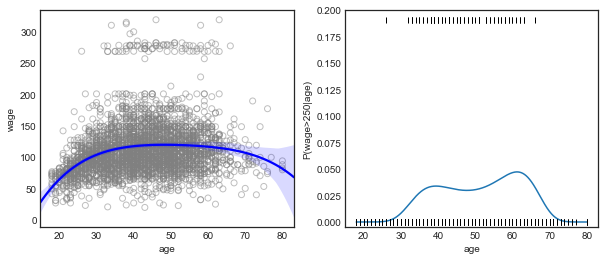

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.scatter(df_wage.age, df_wage.wage, facecolors='None', edgecolors='grey', alpha=.5)
# seaborn uses np.polyfit to fit a polynomial of order 4 to the data, basically the same we did with sklearn
sns.regplot(df_wage.age, df_wage.wage, ci=100, label='Degree 4', order=4, scatter=False, color='blue', ax=ax1)

age_range = np.linspace(df_logistic_wage.age.min(), df_logistic_wage.age.max(), 1000).reshape((-1, 1))
# Apply transforms to the data, and predict with the final estimator
predictions = pipe.predict_proba(age_range)[:, 1]
# probability of wage > 250 given age
ax2.plot(age_range, predictions)
ax2.set_ylim(ymin=-0.005, ymax=0.2)
# rug plot
ax2.plot(X, y*0.19, '|', color='k')
ax2.set_xlabel('age')
ax2.set_ylabel('P(wage>250|age)');

## 7.2 Step Functions

In [8]:
# fit a stepwise function to wage data. Use four bins like in Figure 7.2
num_bins = 4

df_step = pd.DataFrame(pd.cut(df_wage.age, num_bins))
df_step = pd.get_dummies(df_step)
df_step['wage'] = df_wage.wage
df_step['age'] = df_wage.age
df_step.head(3)

,"age_(17.938, 33.5]","age_(33.5, 49.0]","age_(49.0, 64.5]","age_(64.5, 80.0]",wage,age
0,1,0,0,0,75.043154,18
1,1,0,0,0,70.476020,24
2,0,1,0,0,130.982177,45


In [9]:
# linear regression
linear = skl_lm.LinearRegression()

X = df_step[df_step.columns.difference(['wage', 'age'])]
y = df_step['wage']

linear.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
# logistic regression
df_logistic_step = df_step.copy()
df_logistic_step['large_wage'] = (df_logistic_step['wage'].values > 250).astype(int)

X = df_logistic_step[df_step.columns.difference(['wage', 'age', 'large_wage'])]
y = df_logistic_step['large_wage']

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('logistic', skl_lm.LogisticRegression(C=1e10))])
# Fit all the transforms one after the other and transform the data, then fit the transformed data using the final estimator.
pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

#### FIGURE 7.2

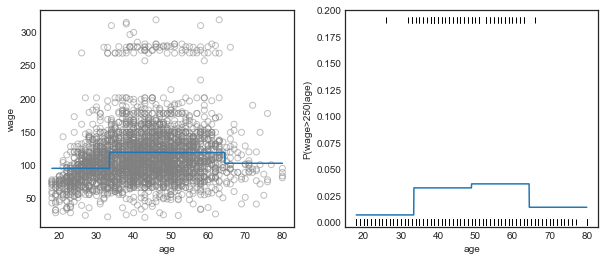

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.scatter(df_step.age, df_step.wage, facecolors='None', edgecolors='grey', alpha=.5)

age_range = np.linspace(df_step.age.min(), df_step.age.max(), 1000)
age_range_dummies = pd.get_dummies(pd.cut(age_range, num_bins))
predictions = linear.predict(age_range_dummies)
ax1.plot(age_range, predictions)
ax1.set_xlabel('age')
ax1.set_ylabel('wage')

# Apply transforms to the data, and predict with the final estimator
predictions = pipe.predict_proba(age_range_dummies)[:, 1]
# probability of wage > 250 given age
ax2.plot(age_range, predictions)
ax2.set_ylim(ymin=-0.005, ymax=0.2)
# rug plot
ax2.plot(df_step.age, y*0.19, '|', color='k')
ax2.set_xlabel('age')
ax2.set_ylabel('P(wage>250|age)');

## 7.3 Basis Functions

## 7.4 Regression Splines

In [12]:
X = df_wage['age'].values.reshape(-1, 1)
y = df_wage['wage']
knots = np.percentile(X, [25, 50, 75])

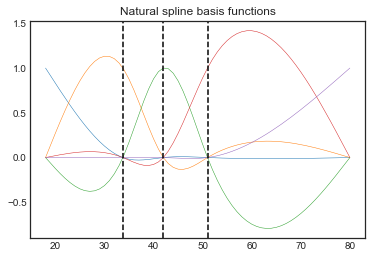

In [13]:
spline_basis_plot = dmatrix("cr(x, knots=knots) -1", {"x": np.sort(X, axis=0), 'knots': knots}, return_type='dataframe')
plt.plot(np.sort(X, axis=0), spline_basis_plot.values, '-', linewidth=0.5)
for knot in knots:
    plt.axvline(knot, ls='--', color='k')
plt.title('Natural spline basis functions');

In [14]:
# Use Patsy to generate the splines, but package it in a easier way
from splines import PatsySplineFeatures
X = df_wage['age'].values.reshape(-1, 1)
y = df_wage['wage']
knots = np.percentile(X, [25, 50, 75])
patsy_features = PatsySplineFeatures(knots)

#### FIGURE 7.5

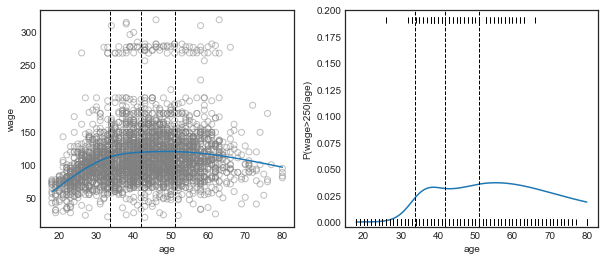

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

age_range = np.linspace(df_wage.age.min(), df_wage.age.max(), 1000).reshape((-1, 1))

# linear regression
linear_model = make_pipeline(patsy_features, skl_lm.LinearRegression())
linear_model.fit(X, y)
y_pred_linear = linear_model.predict(age_range)

ax1.scatter(df_wage.age, df_wage.wage, facecolors='None', edgecolors='grey', alpha=.5)
ax1.plot(age_range, y_pred_linear)
ax1.set_xlabel('age')
ax1.set_ylabel('wage')

# probability of wage > 250 given age
y_log = (df_wage['wage'].values > 250).astype(int)
log_model = make_pipeline(patsy_features, skl_lm.LogisticRegression(C=1e10))
log_model.fit(X, y_log)
y_pred_log = log_model.predict_proba(age_range)[:, 1]

ax2.plot(age_range, y_pred_log)
ax2.set_ylim(ymin=-0.005, ymax=0.2)
# rug plot
ax2.plot(df_wage.age, y_log*0.19, '|', color='k')
ax2.set_xlabel('age')
ax2.set_ylabel('P(wage>250|age)')

for ax in (ax1, ax2):
    for knot in knots:
        ax.axvline(knot, ls='--', color='k', linewidth=1)

#### Using SciPy spline basis

In [16]:
# Use scipy in a nicer packaged way
from splines import BSplineFeatures, NaturalSplineFeatures

In [17]:
X = df_wage['age'].values.reshape(-1, 1)
y = df_wage['wage']
knots = np.percentile(X, [0, 25, 50, 75, 100])
bspline_features = BSplineFeatures(knots, degree=3)

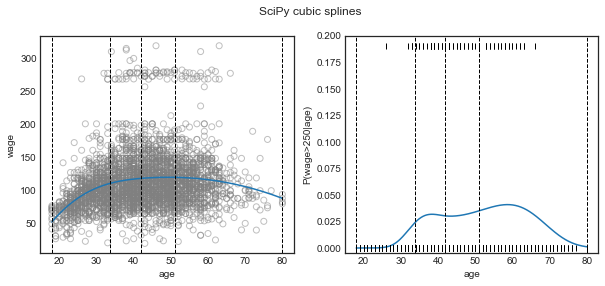

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('SciPy cubic splines')

age_range = np.linspace(df_wage.age.min(), df_wage.age.max(), 1000).reshape((-1, 1))

# linear regression
linear_model = make_pipeline(bspline_features, skl_lm.LinearRegression())
linear_model.fit(X, y)
y_pred_linear = linear_model.predict(age_range)

ax1.scatter(df_wage.age, df_wage.wage, facecolors='None', edgecolors='grey', alpha=.5)
ax1.plot(age_range, y_pred_linear)
ax1.set_xlabel('age')
ax1.set_ylabel('wage')

# probability of wage > 250 given age
y_log = (df_wage['wage'].values > 250).astype(int)
log_model = make_pipeline(bspline_features, skl_lm.LogisticRegression(C=1e10))
log_model.fit(X, y_log)
y_pred_log = log_model.predict_proba(age_range)[:, 1]

ax2.plot(age_range, y_pred_log)
ax2.set_ylim(ymin=-0.005, ymax=0.2)
# rug plot
ax2.plot(df_wage.age, y_log*0.19, '|', color='k')
ax2.set_xlabel('age')
ax2.set_ylabel('P(wage>250|age)')

for ax in (ax1, ax2):
    for knot in knots:
        ax.axvline(knot, ls='--', color='k', linewidth=1)

#### Use scipy natural splines

In [19]:
X = df_wage['age'].values.reshape(-1, 1)
y = df_wage['wage']
knots = np.percentile(X, [0, 25, 50, 75, 100])
natural_features = NaturalSplineFeatures(knots)

In [20]:
# it seems that changing this coefficient the spline resembles the natural spline generated by patsy above
# There should be an equation to find the right values...
natural_features.natsplines[4][1][5] = 0.5

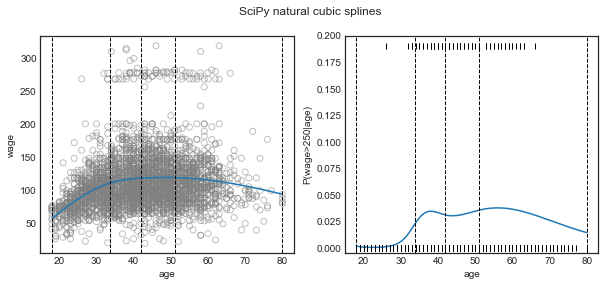

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('SciPy natural cubic splines')

age_range = np.linspace(df_wage.age.min(), df_wage.age.max(), 1000).reshape((-1, 1))

# linear regression
linear_model = make_pipeline(natural_features, skl_lm.LinearRegression())
linear_model.fit(X, y)
y_pred_linear = linear_model.predict(age_range)

ax1.scatter(df_wage.age, df_wage.wage, facecolors='None', edgecolors='grey', alpha=.5)
ax1.plot(age_range, y_pred_linear)
ax1.set_xlabel('age')
ax1.set_ylabel('wage')

# probability of wage > 250 given age
y_log = (df_wage['wage'].values > 250).astype(int)
log_model = make_pipeline(natural_features, skl_lm.LogisticRegression(C=1e10))
log_model.fit(X, y_log)
y_pred_log = log_model.predict_proba(age_range)[:, 1]

ax2.plot(age_range, y_pred_log)
ax2.set_ylim(ymin=-0.005, ymax=0.2)
# rug plot
ax2.plot(df_wage.age, y_log*0.19, '|', color='k')
ax2.set_xlabel('age')
ax2.set_ylabel('P(wage>250|age)')

for ax in (ax1, ax2):
    for knot in knots:
        ax.axvline(knot, ls='--', color='k', linewidth=1)

### Degrees of freedom

In [22]:
X = df_wage['age'].values.reshape(-1, 1)
y = df_wage['wage'].values

In [23]:
errors_natural = []
degrees = range(4, 10)
for df in degrees:
    linear_model = make_pipeline(PatsySplineFeatures(df=df), skl_lm.LinearRegression())
    score = cross_val_score(linear_model, X, y, cv=10, scoring='neg_mean_squared_error')
    errors_natural.append(-score.mean())

In [24]:
X = df_wage['age'].values.reshape(-1, 1)
y = df_wage['wage'].values

errors_cubic = []
degrees = range(4, 10)
for df in degrees:
    knots = np.percentile(X, np.linspace(0, 100, df))
    linear_model = make_pipeline(BSplineFeatures(knots), skl_lm.LinearRegression())
    
    score = cross_val_score(linear_model, X, y, cv=10, scoring='neg_mean_squared_error')
    errors_cubic.append(-score.mean())

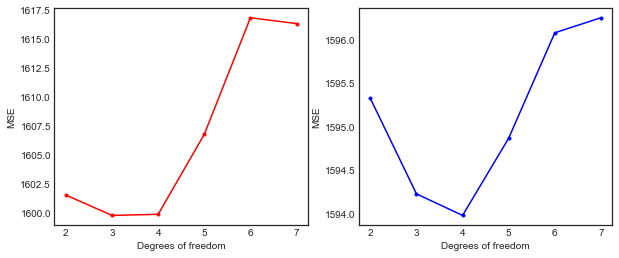

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# substract the two outer knots
ax1.plot(np.array(degrees)-2, errors_natural, 'r.-');

ax2.plot(np.array(degrees)-2, errors_cubic, 'b.-');

for ax in (ax1, ax2):
    ax.set_xlabel('Degrees of freedom')
    ax.set_ylabel('MSE')

## 7.5 Smoothing Splines

In [26]:
from splines import SmoothingSpline
X = df_wage['age'].values.reshape(-1, 1)
y = df_wage['wage'].values

In [27]:
smoothing_spline_df16 = SmoothingSpline(s=2.8e3)
smoothing_spline_df16.fit(X, y)
smoothing_spline_df7 = SmoothingSpline(s=3.75e3)
smoothing_spline_df7.fit(X, y);

#### FIGURE 7.8

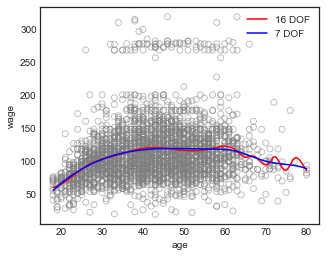

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

age_range = np.linspace(df_wage.age.min(), df_wage.age.max(), 1000).reshape((-1, 1))
y_pred_df16 = smoothing_spline_df16.predict(age_range)
y_pred_df7 = smoothing_spline_df7.predict(age_range)

ax.scatter(X, y, facecolors='None', edgecolors='grey', alpha=.5)
ax.plot(age_range, y_pred_df16, 'r', label='16 DOF')
ax.plot(age_range, y_pred_df7, 'b', label='7 DOF')
ax.set_xlabel('age')
ax.set_ylabel('wage')
ax.legend();

In [29]:
errors_smooth = []
smoothing = np.logspace(2, 6, 10)
for s in smoothing:
    score = cross_val_score(SmoothingSpline(s=s), X, y, cv=10, scoring='neg_mean_squared_error')
    errors_smooth.append(-score.mean())

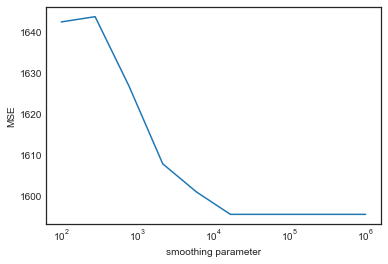

In [30]:
plt.semilogx(smoothing, errors_smooth);
plt.xlabel('smoothing parameter')
plt.ylabel('MSE');

## 7.6 Local Regression

In [31]:
import local_regressor

In [32]:
X = df_wage['age'].values.reshape(-1, 1)
y = df_wage['wage'].values
age_range = np.linspace(df_wage.age.min(), df_wage.age.max(), 1000).reshape((-1, 1))

In [33]:
n_neighbors = len(X)  # all NN, use sigma to control local influence
# sigma is related to the maximum distance between neighbors (in years)
sigmas = [0.1, 1, 10, 100]
y_preds = []
for sigma in sigmas:
    kernel = lambda dist: np.exp(-dist**2/(2*sigma**2))
    local_regression = local_regressor.LocalRegressor(n_neighbors, weights=kernel)
    local_regression.fit(X, y)
    y_preds.append(local_regression.predict(age_range))

#### FIGURE 7.10

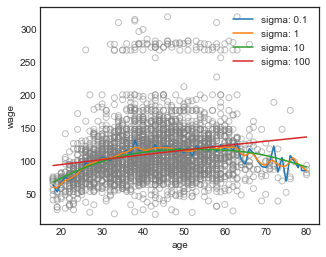

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.scatter(X, y, facecolors='None', edgecolors='grey', alpha=.5)
for num, sigma in enumerate(sigmas):
    ax.plot(age_range, y_preds[num], label=f'sigma: {sigma}')
ax.legend();
ax.set_xlabel('age')
ax.set_ylabel('wage');

## 7.7 Generalized Additive Models

In [75]:
from pygam import LinearGAM, LogisticGAM
from pygam.utils import generate_X_grid
X = pd.concat((df_wage[['year', 'age']], df_wage.education.cat.codes), axis=1)
X.rename(columns={0: "education"}, inplace=True)
y = df_wage['wage']

In [76]:
X.head(3)

,year,age,education
0,2006,18,0
1,2004,24,3
2,2003,45,2


### 7.7.1 GAMs for Regression Problems

In [107]:
gam = LinearGAM(n_splines=10).gridsearch(X, y)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [108]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      13.532
Link Function:                     IdentityLink Log Likelihood:                                -24119.2334
Number of Samples:                         3000 AIC:                                            48267.5307
                                                AICc:                                            48267.682
                                                GCV:                                             1247.0706
                                                Scale:                                           1236.9495
                                                Pseudo R-Squared:                                   0.2926
Feature Function   Data Type      Num

#### FIGURE 7.11

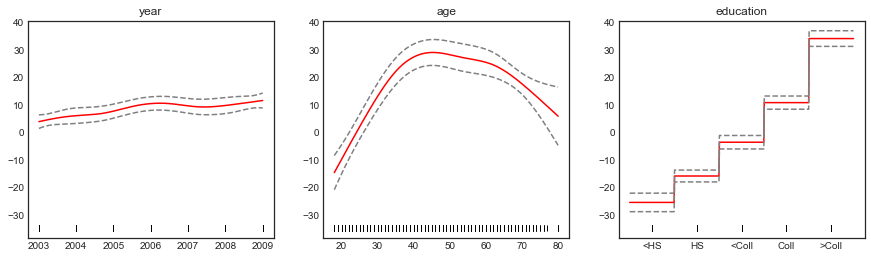

In [112]:
XX = generate_X_grid(gam)
fig, axs = plt.subplots(1, len(X.columns), sharey=True, figsize=(15,4))
titles = X.columns
for i, ax in enumerate(axs):
    pdep, confi = gam.partial_dependence(XX, feature=i+1, width=.95)
    ax.plot(XX[:, i], pdep, 'r')
    ax.plot(XX[:, i], confi[0][:, 0], c='grey', ls='--')
    ax.plot(XX[:, i], confi[0][:, 1], c='grey', ls='--')
    ax.plot(X.iloc[:,i], np.ones_like(X.iloc[:,i])*(-35), '|', color='k')
    ax.set_title(titles[i])

axs[2].xaxis.set_ticklabels(['', '<HS', 'HS', '<Coll', 'Coll', '>Coll'])
axs[1].yaxis.set_tick_params(labelleft=True)
axs[2].yaxis.set_tick_params(labelleft=True)
plt.show()

### 7.7.2 GAMs for Classification Problems

In [40]:
y_log = (y > 250).astype(int)

In [41]:
gam_log = LogisticGAM(n_splines=10).gridsearch(X, y_log)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


#### FIGURE 7.13

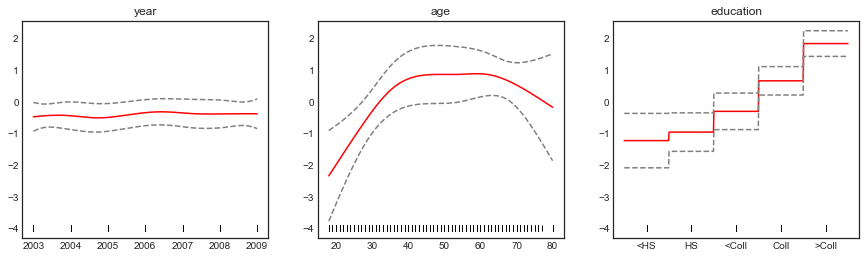

In [59]:
XX = generate_X_grid(gam_log)
fig, axs = plt.subplots(1, len(X.columns), sharey=True, figsize=(15,4))
titles = X.columns
for i, ax in enumerate(axs):
    pdep, confi = gam_log.partial_dependence(XX, feature=i+1, width=.95)
    ax.plot(XX[:, i], pdep, 'r')
    ax.plot(XX[:, i], confi[0][:, 0], c='grey', ls='--')
    ax.plot(XX[:, i], confi[0][:, 1], c='grey', ls='--')
    ax.plot(X.iloc[:,i], np.ones_like(X.iloc[:,i])*(-4), '|', color='k')
    ax.set_title(titles[i])

axs[2].xaxis.set_ticklabels(['', '<HS', 'HS', '<Coll', 'Coll', '>Coll'])
axs[1].yaxis.set_tick_params(labelleft=True)
axs[2].yaxis.set_tick_params(labelleft=True)

In [43]:
X_no_less_HS = X[X.education > 0]
gam_log_no_less_HS = LogisticGAM(n_splines=10).gridsearch(X_no_less_HS, y_log[X.education > 0])

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


#### FIGURE 7.14

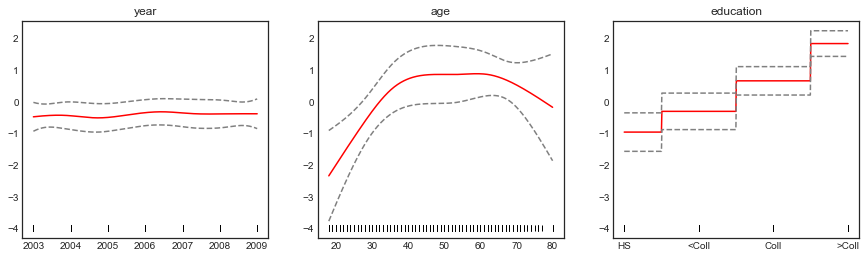

In [70]:
XX = generate_X_grid(gam_log_no_less_HS)
fig, axs = plt.subplots(1, len(X.columns), sharey=True, figsize=(15,4))
titles = X.columns
for i, ax in enumerate(axs):
    pdep, confi = gam_log.partial_dependence(XX, feature=i+1, width=.95)
    ax.plot(XX[:, i], pdep, 'r')
    ax.plot(XX[:, i], confi[0][:, 0], c='grey', ls='--')
    ax.plot(XX[:, i], confi[0][:, 1], c='grey', ls='--')
    ax.plot(X_no_less_HS.iloc[:,i], np.ones_like(X_no_less_HS.iloc[:,i])*(-4), '|', color='k')
    ax.set_title(titles[i])

axs[2].xaxis.set_ticklabels(['HS', '<Coll', 'Coll', '>Coll'])
axs[2].xaxis.set_ticks(range(1, 5))
axs[1].yaxis.set_tick_params(labelleft=True)
axs[2].yaxis.set_tick_params(labelleft=True)

## 7.8 Lab: Non-linear Modeling

### 7.8.1 Polynomial Regression and Step Functions

In [45]:
# Figure 1 has been done in Section 7.1
# Figure 2 in Section 7.2

In [46]:
X1 = PolynomialFeatures(1).fit_transform(df_wage.age.values.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(df_wage.age.values.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(df_wage.age.values.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(df_wage.age.values.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(df_wage.age.values.reshape(-1,1))
fit_1 =  sm.GLS(df_wage.wage, X1).fit()
fit_2 =  sm.GLS(df_wage.wage, X2).fit()
fit_3 =  sm.GLS(df_wage.wage, X3).fit()
fit_4 =  sm.GLS(df_wage.wage, X4).fit()
fit_5 =  sm.GLS(df_wage.wage, X5).fit()

sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1)

C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


### 7.8.2 Splines

In [47]:
# Done in Sections 7.3 and 7.4

### 7.8.3 GAMs

In [263]:
def plot_GAM_model(gam_model, dataX):
    XX = generate_X_grid(gam_model)
    fig, axs = plt.subplots(1, len(dataX.columns), sharey=True, figsize=(15,4))
    titles = dataX.columns
    for i, ax in enumerate(axs):
        pdep, confi = gam_model.partial_dependence(XX, feature=i+1, width=.95)
        ax.plot(XX[:, i], pdep, 'r')
        ax.plot(XX[:, i], confi[0][:, 0], c='grey', ls='--')
        ax.plot(XX[:, i], confi[0][:, 1], c='grey', ls='--')
        ax.plot(dataX.iloc[:,i], np.ones_like(dataX.iloc[:,i])*(-35), '|', color='k')
        ax.set_title(titles[i])

    axs[-1].xaxis.set_ticklabels(['', '<HS', 'HS', '<Coll', 'Coll', '>Coll'])
    axs[1].yaxis.set_tick_params(labelleft=True)
    axs[-1].yaxis.set_tick_params(labelleft=True)

In [248]:
# Most of it done in Section 7.7
# Here we compare 3 models:
# 1: no year
# 2: linear year
# 3: splines year
# for all three age is modelled with 5 cubic splines

In [245]:
X = pd.concat((df_wage[['year', 'age']], df_wage.education.cat.codes), axis=1)
X.rename(columns={0: "education"}, inplace=True)
y = df_wage['wage']

In [228]:
gam_no_year = LinearGAM(n_splines=[5, 5], spline_order=[3, 0], penalties='none').gridsearch(X[['age', 'education']], y)
# use 2 splines of order 1 to fit a linear model to year
gam_linear_year = LinearGAM(n_splines=[2, 5, 5], spline_order=[1, 3, 0], penalties='none').gridsearch(X, y)
gam_splines_year = LinearGAM(n_splines=[4, 5, 5], spline_order=[3, 3, 0], penalties='none').gridsearch(X, y)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [229]:
gam_linear_year.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                        10.0
Link Function:                     IdentityLink Log Likelihood:                                -24122.8967
Number of Samples:                         3000 AIC:                                            48267.7934
                                                AICc:                                           48267.8818
                                                GCV:                                             1245.9343
                                                Scale:                                           1238.4609
                                                Pseudo R-Squared:                                   0.2909
Feature Function   Data Type      Num

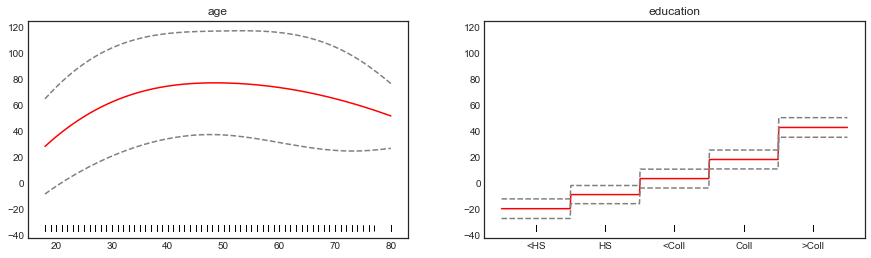

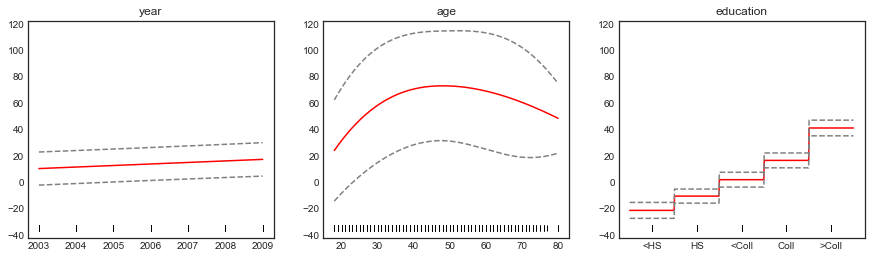

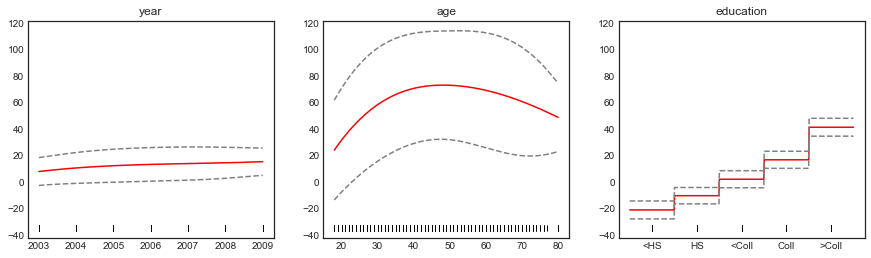

In [264]:
plot_GAM_model(gam_no_year, X[['age', 'education']])
plot_GAM_model(gam_linear_year, X)
plot_GAM_model(gam_splines_year, X)

In [233]:
for model in [gam_no_year, gam_linear_year, gam_splines_year]:
    print(model.statistics_['AIC'])

48290.3854781
48267.7934447
48273.2244633


#### The best model is the one with the lowest AIC, in this case the model with a linear year
#### This happens both with or without penalization

#### It's not possible to use Local regression with pyGAM